# What Makes A Best Original Screenplay?

    By Allison Ragan and Allison Shafer
    American University
    STAT-696 Applied Natural Language Processing

# Analysis

# Table of Contents

    I. Package Imports
    II. NLP Transformations
        i. CountVectorized
        ii. TFIDF
    III. Sentiment Analysis
        i. Sentiment Analysis -- Dialogue
        ii. Sentiment Analysis -- Full Script
    IV. Topic Modeling
        i. Topic Modeling -- Dialogue
        ii. Topic Modeling -- Full Script
    V. K-Means Clustering
        i. K-Means Clustering -- Dialogue
        ii. K-Means Clustering -- Full Script
    VI. Results

## Package Imports

In [4]:
import pandas as pd 
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import NMF as nmf
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import wordcloud # may need to install
from plotnine import * # may need to install; ggplot included
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.manifold import TSNE

from afinn import Afinn


In [5]:
# Read in .csv to dataframe

movies_df = pd.read_csv('./movies_df.csv')
movies_df.head()

,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime
0,0,First_Reformed,Scripts.com\n\nFirst Reformed\n\nBy Paul Schra...,2018,0,NaN,Ragan,keep journal word program digital file longhan...,bird calling distance toller keep journal word...,4362,4310,Drama,Drama,R,93,68,108
1,1,GreenBook,GREEN BOOK \n\nWritten by \n\nNick Vallelonga ...,2018,1,Win,Ragan,thank much welcome jules podell copacabana bob...,fade title card new york city 1962 ext copacab...,12731,7640,Drama,Drama,PG-13,78,91,130
2,2,Hell_or_HighWater,Scripts.com\n\nHell or High Water\n\nBy Taylor...,2016,0,Nom,Ragan,quiet open door open door devil please stand t...,quiet open door open door devil please stand t...,3627,3627,Drama,Mystery Suspense,R,97,88,102
3,3,LadyBird,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \...,2017,0,Nom,Ragan,making bed looking back loan scholarship world...,anybody talk california hedonism ha never spe...,10058,6237,Comedy-Drama,Comedy-Drama,R,99,79,93
4,4,LaLaLand,LA LA LAND\n\nby\n\nDamien Chazelle\n\n A sun-...,2016,0,Nom,Ragan,think going worst working like gon na talk tal...,sunblasted sky hear radio one piece music ano...,9817,6853,Comedy-Drama,Comedy-Drama,PG-13,91,81,128


## Data Visualizations

## Prep Data for Analysis


In [6]:
# Created grouped data

Genres_df = movies_df.groupby(["GenresBroad"])

Win_Lose = movies_df.groupby('orig_screen_win')

# sanity check on grouping
Genres_df.agg({'dialogue_length':sum})

Win_Lose.agg({'dialogue_length':sum})


# Group text by Genre for analysis
text_group_genre = Genres_df['cleaned_dialogue'].apply(' '.join).reset_index()

text_group_genre = pd.DataFrame(text_group_genre)

# Group text by winner/loser for analysis

win_lose_text = Win_Lose['cleaned_dialogue'].apply(' '.join).reset_index()

## NLP transformations

### CV

In [7]:
# instantiate

# all scripts and visuals 
bow_all = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = .2)
# fit + transform training data
bow_all_fit = bow_all.fit_transform(movies_df['cleaned_script'])

# for dialogue only
bow_dialogue = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = .2)
# fit + transform training data
bow_dialogue_fit = bow_dialogue.fit_transform(movies_df['cleaned_dialogue'])

### TFIDF

In [8]:
# instantiate - All parts of script
tfidf_all = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')

# fit + transform training data - all scripts and visuals

tfidf_all_fit = tfidf_all.fit(movies_df['cleaned_script'])
tfidf_vocab_all = tfidf_all_fit.vocabulary_
tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_all)


# instantiate - Dialogue Only
tfidf_dialogue = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')

# fit + transform training data - dialogue only 
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_dialogue)

# Sentiment Analysis

Using AFINN lexicon, aka the "new ANEW" which calculates a polarity score associated with each word.


### Sentiment Analysis -- Dialogue

In [9]:
# initialize afinn sentiment analyzer
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_dialogue'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_dialogue = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_dialogue.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_dialogue['SentimentScore'] = afinn_dialogue['SentimentScore'].astype('float')

#### Winners vs Losers

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Result')

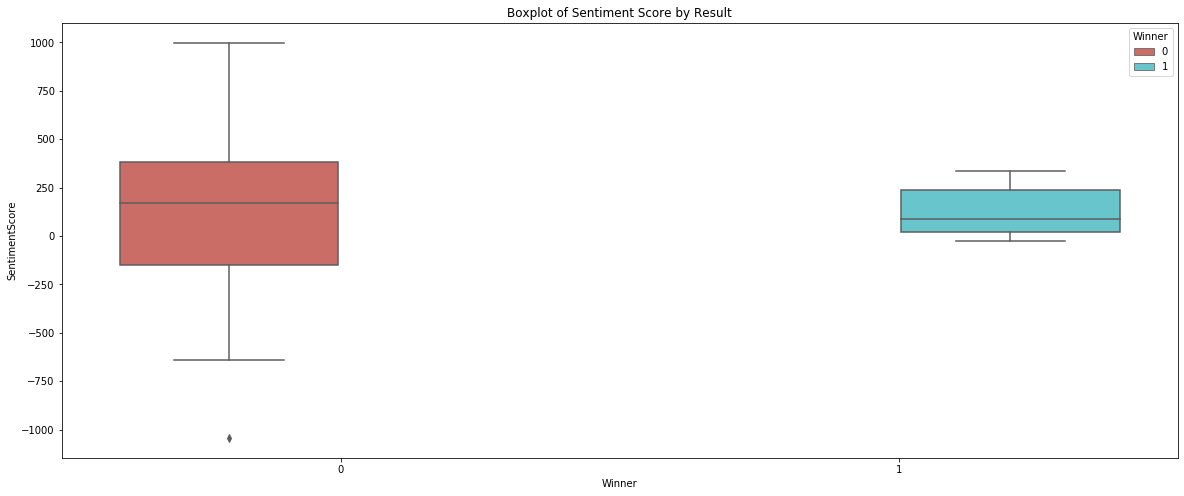

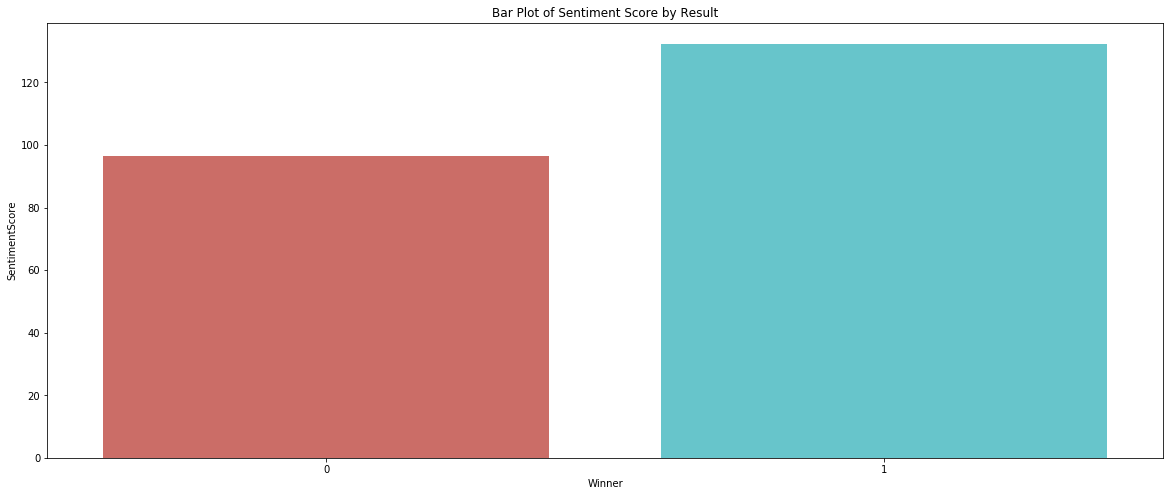

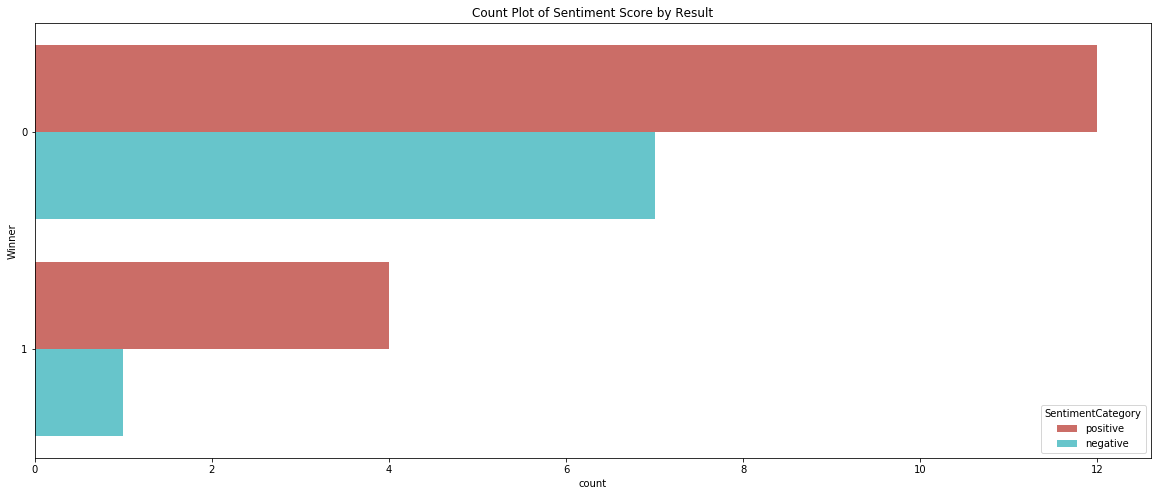

In [10]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Winner', y="SentimentScore", 
                 hue='Winner', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Result')

# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Result')

# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Winner", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Result')

#### Genres

Text(0.5, 1.0, 'Count Plot of Sentiment Score by GenreBroad')

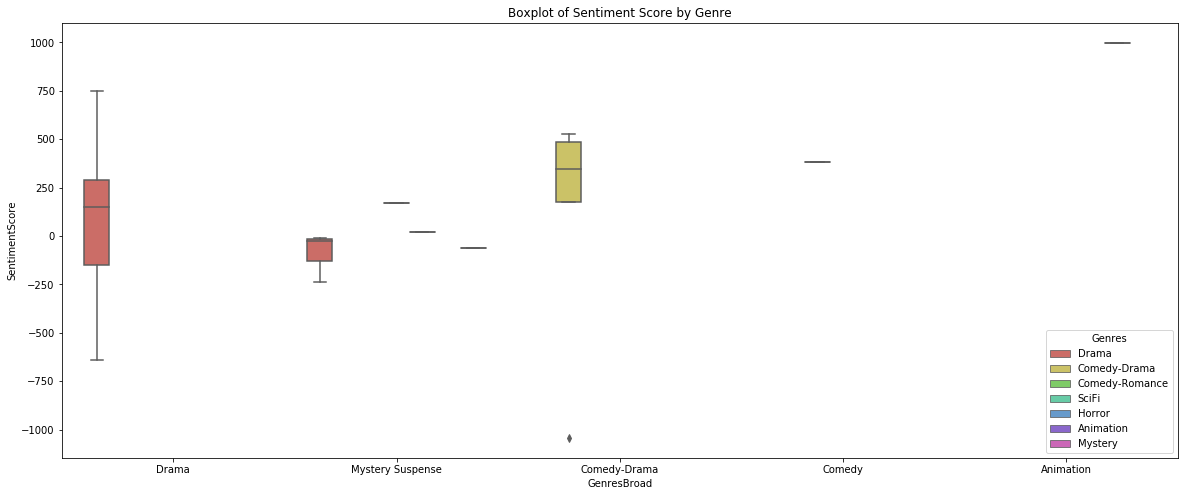

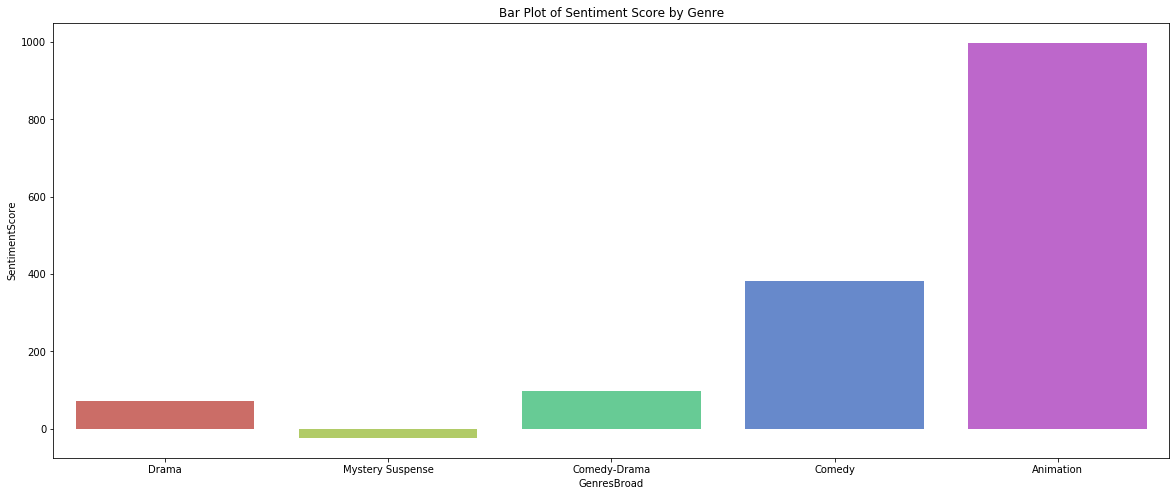

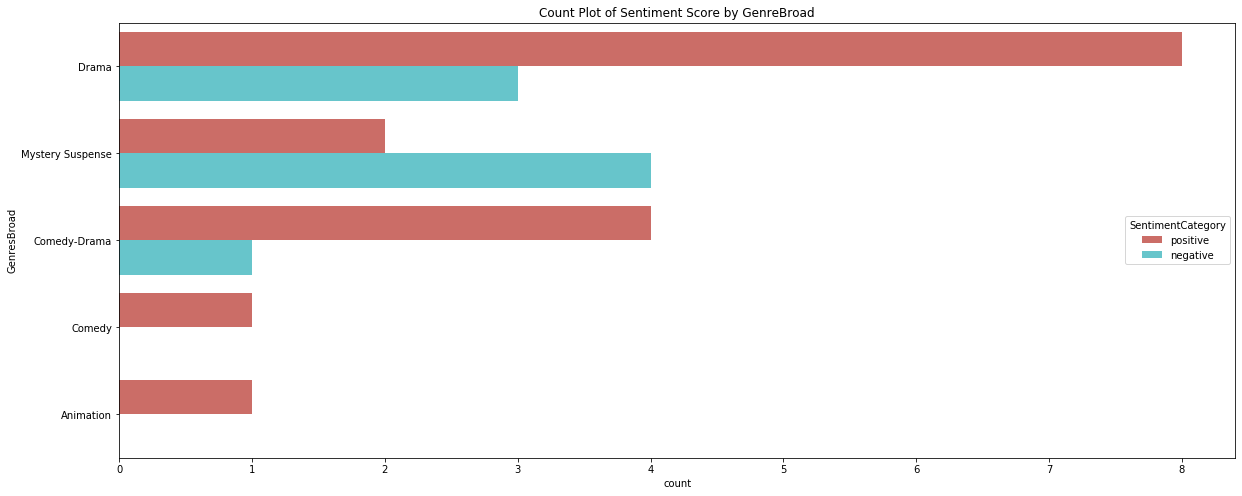

In [11]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['GenresBroad']).describe()

# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='GenresBroad', y="SentimentScore", 
                 hue='Genres', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "GenresBroad", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="GenresBroad", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Genre')

### Sentiment Analysis -- Full Script

In [ ]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_script'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_all = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_all.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_all['SentimentScore'] = afinn_all['SentimentScore'].astype('float')

#### Winners vs Losers

In [ ]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Winner', y="SentimentScore", 
                 hue='Winner', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Result')

# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Result')

# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Winner", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Result')

#### Genres

In [ ]:
# sentiment statistics for winners/losers
afinn_all.groupby(by=['GenresBroad']).describe()

# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='GenresBroad', y="SentimentScore", 
                 hue='Genres', data=afinn_all, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Genre')

# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "GenresBroad", y = "SentimentScore", ax=ax, data=afinn_all, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Genre')

# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="GenresBroad", hue="SentimentCategory", data=afinn_all, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by GenreBroad')

## Topic Modeling -- AS

### TFIDF/ NMF

### Topic Modeling -- Dialogue

In [17]:
# instantiate
tfidf_dialogue = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')

# fit + transform training data - dialogue only 
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
# tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_dialogue)

tf_diag_feat = tfidf_dialogue.get_feature_names()
len(tf_diag_feat)

2920

In [18]:
n = nmf(n_components = 10).fit(tfidf_dialogue_fit) # set up nmf model for 10 topics - one for each movie?

# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(n, tf_diag_feat, 10) # 20 words per topic



# n = nmf(n_components = 24).fit(tfidf_dialogue_fit) # set up nmf model for 24 topics - one for each movie?

# # function to marry up word value to feature names and output words per topic
# def print_top_words(model, feature_names, n_top_words): 
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic %d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()

# print_top_words(n, tf_diag_feat, 20)


Topic 0: beat sir nod pie egg sign blood grab german corridor
Topic 1: dont im youre thats david shes didnt whats doesnt dont know
Topic 2: na gon gon na fucking uh bank beth fuck ca wan
Topic 3: la charlie los al sofa new york york ok theater ya
Topic 4: lady bird mom mr dad suddenly nod shall horse college
Topic 5: dick power president mary agent war american state mr beat
Topic 6: rose rod picture brooklyn driver dont lawn dining im richard
Topic 7: lip dr christmas piano record glance na gon gon na george
Topic 8: mike boston im church office jim dont joe ca desk
Topic 9: joy sadness memory island im dad thats dont fear mom



### Topic Modeling -- Full Script

In [23]:
# instantiate
tfidf_all = TfidfVectorizer(ngram_range = (1,2), max_df = .8, min_df = .25, stop_words = 'english')

# fit + transform training data - all scripts and visuals
tfidf_all_fit = tfidf_all.fit_transform(movies_df['cleaned_script'])
#tfidf_vocab_all = tfidf_all_fit.vocabulary_
#tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
#print(tfidf_vocab_all)


tf_all_feat = tfidf_all.get_feature_names()
len(tf_all_feat)

2915

In [24]:
n = nmf(n_components = 10).fit(tfidf_all_fit) # set up nmf model for 10 topics

# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(n, tf_all_feat, 10)


# n = nmf(n_components = 24).fit(tfidf_all_fit) # set up nmf model for 24 topics

# # function to marry up word value to feature names and output words per topic
# def print_top_words(model, feature_names, n_top_words): 
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic %d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()
    
# print_top_words(n, tf_all_feat, 10)

Topic 0: cont apartment richard pie party os mr shooting sir corridor
Topic 1: contd dont im youre thats william power doesnt shes rose
Topic 2: na gon gon na mary bank cube um ca leaning fucking
Topic 3: charlie james os police station continuous police ya pause fucking road
Topic 4: lip dr cont tony george continuous joe ok stage apartment
Topic 5: lady bird cont mom mr shooting 14 os sister college
Topic 6: dick david bush president hotel waiter george mary manager agent
Topic 7: la sofa los cont patio cube da le ya record
Topic 8: joy sadness memory fear anger mom dad island contd san
Topic 9: mike im jim joe church dont thats law contd cube



In [22]:
# Add Topics to dataframe # by dialogue

topic_values = n.transform(tfidf_dialogue_fit)
movies_df['Dia_Topic'] = topic_values.argmax(axis = 1)


In [25]:
# Add Topics to dataframe # by full script

topic_values = n.transform(tfidf_all_fit)
movies_df['Full_Topic'] = topic_values.argmax(axis = 1)

,orig_screen_win,cleaned_dialogue
0,0,keep journal word program digital file longhan...
1,1,thank much welcome jules podell copacabana bob...



## K Means Clustering  -- AR

Either on CV and TFIDF, or just on NMF

In [ ]:
def eval_k(kmeans, centroids, terms):
    cluster_terms = []
    for i in range(kmeans.n_clusters):
        termss = []
        for ind in centroids[i, :10]:
            termss.append(terms[ind])
        cluster_terms.append(termss)
    for i in range(kmeans.n_clusters):
        print(f'\tCluster {i+1}: {" ".join(cluster_terms[i])}')

### K Means Clustering -- Dialogue

#### CV

In [ ]:
# get feature names
bow_dialogue_feat_names = bow_dialogue.get_feature_names()

In [ ]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(bow_dialogue_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Dialogue Bag of Words')
plt.show()

In [ ]:
# K-Means with Count Vectorized
k_bow_dialogue = KMeans(n_clusters = 2, random_state = 0).fit(bow_dialogue_fit)
k_bow_dialogue_centroids = k_bow_dialogue.cluster_centers_.argsort()[:, ::-1]
k_bow_dialogue_terms = bow_dialogue_feat_names
k_bow_dialogue_labels = k_bow_dialogue.labels_

print("Count Vectorized Dialogue:")
eval_k(k_bow_dialogue, k_bow_dialogue_centroids, k_bow_dialogue_terms)

#### TFIDF

In [ ]:
# get feature names
tfidf_dialogue_feat_names = tfidf_dialogue.get_feature_names()

In [ ]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(tfidf_dialogue_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Dialogue TFIDF')
plt.show()

In [ ]:
# K-Means with Count Vectorized
k_tfidf_dialogue = KMeans(n_clusters = 2, random_state = 0).fit(tfidf_dialogue_fit)
k_tfidf_dialogue_centroids = k_tfidf_dialogue.cluster_centers_.argsort()[:, ::-1]
k_tfidf_dialogue_terms = tfidf_dialogue_feat_names
k_tfidf_dialogue_labels = k_tfidf_dialogue.labels_

print("TFIDF Dialogue:")
eval_k(k_tfidf_dialogue, k_tfidf_dialogue_centroids, k_tfidf_dialogue_terms)

### K Means Clustering -- Full Script

#### CV

In [ ]:
# get feature names
bow_all_feat_names = bow_all.get_feature_names()

In [ ]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(bow_all_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Full Script Bag of Words')
plt.show()

In [ ]:
# K-Means with Count Vectorized
k_bow_all = KMeans(n_clusters = 2, random_state = 0).fit(bow_all_fit)
k_bow_all_centroids = k_bow_all.cluster_centers_.argsort()[:, ::-1]
k_bow_all_terms = bow_all_feat_names
k_bow_all_labels = k_bow_all.labels_

print("Count Vectorized Full Script:")
eval_k(k_bow_all, k_bow_all_centroids, k_bow_all_terms)

#### TFIDF

In [ ]:
# get feature names
tfidf_all_feat_names = tfidf_all.get_feature_names()

In [ ]:
# Elbow Method to determine optimal k in k means clustering
# calculate sum of squared distances
K = range(1,12)
ssd = [KMeans(n_clusters=k).fit(tfidf_all_fit).inertia_ for k in K]

# plot results
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k with Full Script TFIDF')
plt.show()

In [ ]:
# K-Means with Count Vectorized
k_tfidf_all = KMeans(n_clusters = 2, random_state = 0).fit(tfidf_all_fit)
k_tfidf_all_centroids = k_tfidf_all.cluster_centers_.argsort()[:, ::-1]
k_tfidf_all_terms = tfidf_all_feat_names
k_tfidf_all_labels = k_tfidf_all.labels_

print("TFIDF Full Script:")
eval_k(k_tfidf_all, k_tfidf_all_centroids, k_tfidf_all_terms)

In [ ]:
# from homework 6

# def eval_k(kmeans, centroids, terms):
#     cluster_terms = []
#     for i in range(kmeans.n_clusters):
#         termss = []
#         for ind in centroids[i, :10]:
#             termss.append(terms[ind])
#         cluster_terms.append(termss)
#     for i in range(kmeans.n_clusters):
#         print(f'\tCluster {i+1}: {" ".join(cluster_terms[i])}')

# # K-Means with a) Count Vectorized
# k_cv = KMeans(n_clusters = 20, random_state = 0).fit(cv_tf)
# k_cv_centroids = k_cv.cluster_centers_.argsort()[:, ::-1]
# k_cv_terms = cv_feat_names
# k_cv_labels = k_cv.labels_

# print("Count Vectorized:")
# eval_k(k_cv, k_cv_centroids, k_cv_terms)

# # K-Means with b) TFIDF
# k_tfidf = KMeans(n_clusters = 20, random_state = 0).fit(tfidf)
# k_tfidf_centroids = k_tfidf.cluster_centers_.argsort()[:, ::-1]
# k_tfidf_terms = cv_feat_names
# k_tfidf_labels = k_tfidf.labels_

# print("TFIDF:")
# eval_k(k_tfidf, k_tfidf_centroids, k_tfidf_terms)

# # K-Means with c) NMF -- (1,1), (1,2), (2,3) based on 4
# k_nmf = KMeans(n_clusters = 20, random_state = 0).fit(tfidf_onetwo_matrix)
# k_nmf_centroids = k_nmf.cluster_centers_.argsort()[:, ::-1]
# k_nmf_terms = tfidf_onetwo_feat_names
# k_nmf_labels = k_nmf.labels_

# print("NMF:")
# eval_k(k_nmf, k_nmf_centroids, k_nmf_terms)